In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.linear_model import LogisticRegression, LinearRegression
import src.multielec_utils as mutils

%load_ext autoreload
%autoreload 2

# Load in triplet stim elecResps and amplitudes

In [2]:
dataset = '2021-05-27-4/data003/'
electrical_path = '/Volumes/Analysis/' + dataset

In [3]:
vis_datapath = '/Volumes/Analysis/2021-05-27-4/data001'
vis_datarun = 'data001'
vcd = vl.load_vision_data(vis_datapath, vis_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

coords = vcd.get_electrode_map()

In [4]:
ps = np.array([24, 25, 29, 30, 31, 32])
n = 3352

In [5]:
def potential(p, I, rvec):
    """ Calculate radial electric field 
    Parameters
    ----------
        pe  : resistivity of extracellular medium [kOhm*cm]
        Iel : current through electrode [uA]
        rvec   : vector between point of interest and electrode [cm]
    Returns
    ----------
        V   : value of electric field [mV]
    """

    return p * I / (4 * np.pi * np.linalg.norm(rvec))

In [6]:
def get_volt_profile(Ivec, triplet):
    Vdata = np.zeros((num_points, num_points))
    
    for i in range(len(xaxis)):
        for j in range(len(yaxis)):
            grid_point = np.array([xaxis[i],yaxis[j],z])
            for k in range(len(Ivec)):
                elec_source = np.array([coords[triplet[k] - 1][0], coords[triplet[k] - 1][1],0])
                r_vector = (grid_point - elec_source) * 1e-4 # convert um to cm

                Vdata[i][j] += potential(pe, Ivec[k], r_vector)

    return Vdata

In [7]:
all_coords = []
for p in ps:
    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    all_coords.append(coords[triplet_elecs - 1])

In [8]:
all_coords = np.concatenate(np.array(all_coords), axis=0)
xmin = np.amin(all_coords[:, 0])
xmax = np.amax(all_coords[:, 0])
ymin = np.amin(all_coords[:, 1])
ymax = np.amax(all_coords[:, 1])

In [9]:
pe = 0.3
z = -5
buffer_um = 10
num_points = int(max(xmax - xmin, ymax - ymin) + 2 * buffer_um)

xaxis = np.linspace(xmin - buffer_um, xmax + buffer_um, num_points) 
yaxis = np.linspace(ymin - buffer_um, ymax + buffer_um, num_points)
X, Y = np.meshgrid(xaxis, yaxis)

In [10]:
num_points

80

In [11]:
volts = []
probs = []

for p in ps:
    print(p)
    filepath = '/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity/' + dataset + 'p' + str(p) + '/'
    
    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
        
    num_amps = len(amplitudes)

    p_probs = np.zeros(num_amps)
    for k in range(num_amps):
        with open(filepath + 'gsort_tri_v2_n'+str(n)+'_p'+str(p)+'_k'+str(k)+'.pkl', 'rb') as f:
            prob_dict = pickle.load(f)
            p_probs[k] = prob_dict['prob']

    good_inds = np.where(p_probs > 0.08)[0] 
                         #& (np.any(amps_sorted > 0, axis=1) == False))[0]
        
    cnt = 0
    volt_profiles = np.zeros((len(good_inds), num_points, num_points))

    for m in good_inds:
        Iel = amplitudes[m]

        volt_profiles[cnt] = get_volt_profile(Iel, triplet_elecs)

        print(cnt)
        cnt += 1
    
    volts.append(volt_profiles)
    probs.append(p_probs[good_inds])

24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [12]:
volts = np.concatenate(volts)
probs = np.concatenate(probs)

In [13]:
pos_volt_Rs = np.zeros((num_points, num_points))
neg_volt_Rs = np.zeros((num_points, num_points))

for i in range(len(xaxis)):
    for j in range(len(yaxis)):        
        pos_volt_inds = np.where(volts[:, i, j] >= 0)[0]
        reg = LinearRegression().fit(volts[pos_volt_inds, i, j].reshape(-1, 1), probs[pos_volt_inds])
        pos_volt_Rs[i][j] = np.sqrt(reg.score(volts[pos_volt_inds, i, j].reshape(-1, 1), probs[pos_volt_inds]))
            
        neg_volt_inds = np.where(volts[:, i, j] < 0)[0]
        reg = LinearRegression().fit(-volts[neg_volt_inds, i, j].reshape(-1, 1), probs[neg_volt_inds])
        neg_volt_Rs[i][j] = np.sqrt(reg.score(-volts[neg_volt_inds, i, j].reshape(-1, 1), probs[neg_volt_inds]))

/tmp/ipykernel_42705/1792988779.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor = plt.pcolor(X, Y, pos_volt_Rs.T);


Text(0.5, 0, 'X position ($\\mu$m)')

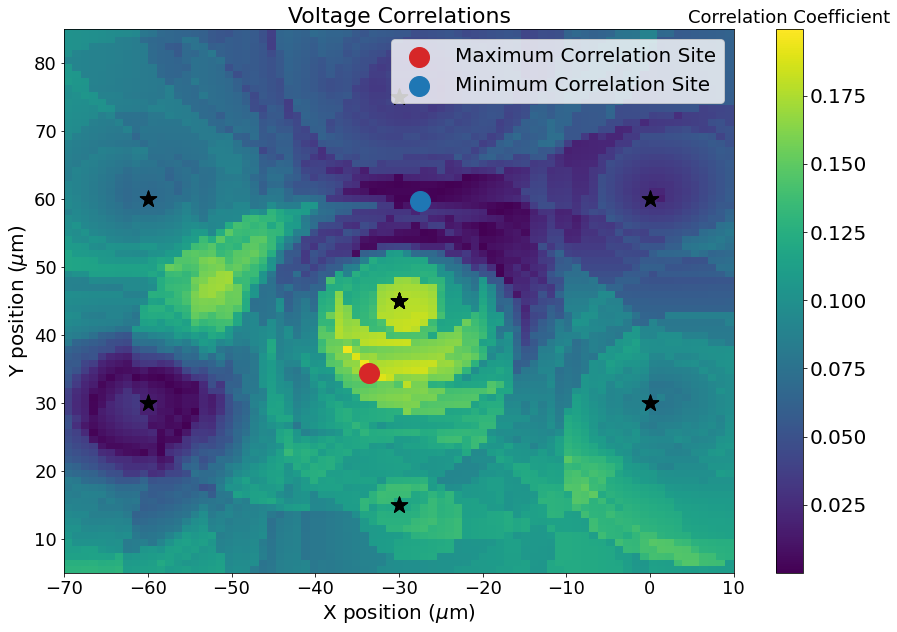

In [14]:
fig,ax = plt.subplots(1,1,figsize=(15,10));
    
pcolor = plt.pcolor(X, Y, pos_volt_Rs.T);
clb = plt.colorbar(pcolor);
clb.ax.tick_params(labelsize=20);
clb.ax.set_title('Correlation Coefficient', fontsize=18);

for p in ps:
    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(triplet_elecs)):
#         txt = ax.text(coords[triplet_elecs[i] - 1, 0],
#                       coords[triplet_elecs[i] - 1, 1],str(triplet_elecs[i]),color='k',fontsize=22);
        ax.scatter(coords[triplet_elecs[i] - 1, 0],
                   coords[triplet_elecs[i] - 1, 1],marker='*',c='k', s=300);
max_pv_corr = np.unravel_index(pos_volt_Rs.argmax(), pos_volt_Rs.shape)
min_pv_corr = np.unravel_index(pos_volt_Rs.argmin(), pos_volt_Rs.shape)
ax.scatter(xaxis[max_pv_corr[0]], yaxis[max_pv_corr[1]], c='tab:red', s=400, label='Maximum Correlation Site')
ax.scatter(xaxis[min_pv_corr[0]], yaxis[min_pv_corr[1]], c='tab:blue', s=400, label='Minimum Correlation Site')
# ax.scatter(-26.69649853,  25.70080885, c='tab:orange', s=400, label='Linear Weight Solution')
plt.title(r'Voltage Correlations', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
# plt.axis('off');
plt.legend(fontsize=20)
plt.ylabel(r'Y position ($\mu$m)', fontsize=20);
plt.xlabel(r'X position ($\mu$m)', fontsize=20)

/tmp/ipykernel_42705/4084378985.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor = plt.pcolor(X, Y, neg_volt_Rs.T);


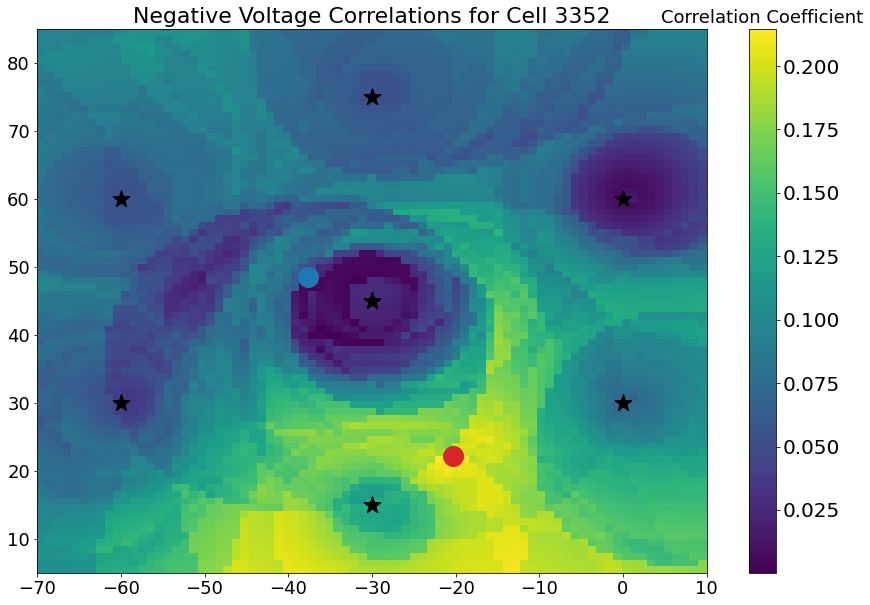

In [15]:
fig,ax = plt.subplots(1,1,figsize=(15,10));
    
pcolor = plt.pcolor(X, Y, neg_volt_Rs.T);
clb = plt.colorbar(pcolor);
clb.ax.tick_params(labelsize=20);
clb.ax.set_title('Correlation Coefficient', fontsize=18);

for p in ps:
    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(triplet_elecs)):
#         txt = ax.text(coords[triplet_elecs[i] - 1, 0],
#                       coords[triplet_elecs[i] - 1, 1],str(triplet_elecs[i]),color='k',fontsize=22);
        ax.scatter(coords[triplet_elecs[i] - 1, 0],
                   coords[triplet_elecs[i] - 1, 1],marker='*',c='k', s=300);
max_nv_corr = np.unravel_index(neg_volt_Rs.argmax(), neg_volt_Rs.shape)
min_nv_corr = np.unravel_index(neg_volt_Rs.argmin(), neg_volt_Rs.shape)
ax.scatter(xaxis[max_nv_corr[0]], yaxis[max_nv_corr[1]], c='tab:red', s=400, label='Maximum Correlation Site')
ax.scatter(xaxis[min_nv_corr[0]], yaxis[min_nv_corr[1]], c='tab:blue', s=400, label='Minimum Correlation Site')
plt.title(r'Negative Voltage Correlations for Cell ' + str(n), fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

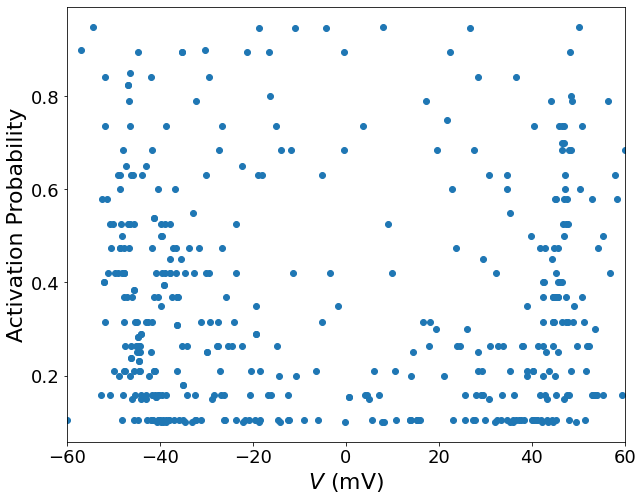

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(volts[:, max_pv_corr[0], max_pv_corr[1]], probs)
plt.xlim(-60, 60)
plt.xlabel(r'$V$ (mV)', fontsize=22);
plt.ylabel('Activation Probability', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

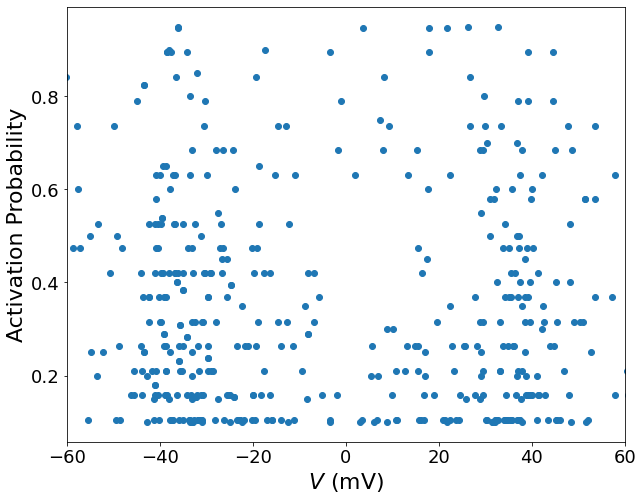

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(volts[:, min_pv_corr[0], min_pv_corr[1]], probs)
plt.xlim(-60, 60)
plt.xlabel(r'$V$ (mV)', fontsize=22);
plt.ylabel('Activation Probability', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

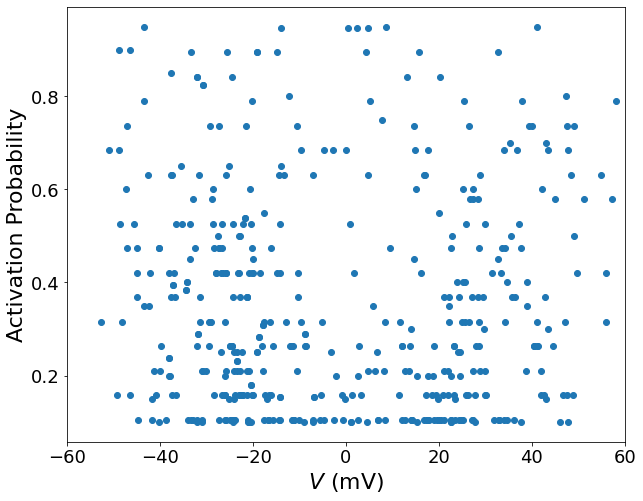

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(volts[:, max_nv_corr[0], max_nv_corr[1]], probs)
plt.xlim(-60, 60)
plt.xlabel(r'$V$ (mV)', fontsize=22);
plt.ylabel('Activation Probability', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

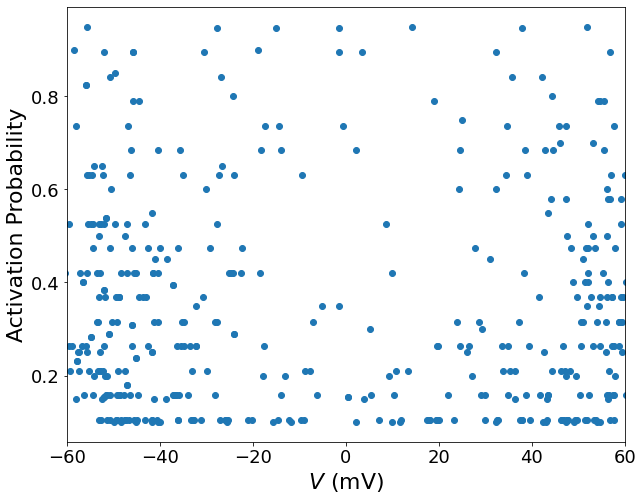

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(volts[:, min_nv_corr[0], min_nv_corr[1]], probs)
plt.xlim(-60, 60)
plt.xlabel(r'$V$ (mV)', fontsize=22);
plt.ylabel('Activation Probability', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);